In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import requests

In [3]:
# Link to the directory where the data is stored
my_dir = "my_path" #insert path to directory where the data from OpenAlex is stored
os.chdir(my_dir)

# General overview of the data gathered from OpenAlex
- Number of publications and authors
- Number of publications per year
- Some basic characteristics of the publications
    - Languages
    - Domains, fields and subfields
    - Countries
- Single authorship vs. co-authorship


## 1. Importing data



In [4]:
# importing the data
df = pd.read_csv("240312_open_alex_works_soc_sci_arts_2010.tsv", sep="\t", index_col=0, low_memory=False)
df.is_in_doaj = df.is_in_doaj.astype(bool)

In [5]:
df.isna().sum()

work_id                       0
doi                        2773
publication_year              0
publication_date              0
publ_type                     0
cited_by_count                0
is_retracted                  0
is_paratext                   0
oa_status                     0
language                    173
is_oa                       363
license                   31170
version                   25711
source_id                  2465
is_in_doaj                    0
issn_l                    12858
source_type                2465
display_name               2465
host_organization_name     7556
country_code              10945
issn                      12858
publisher                  7351
topic                         0
topic_subfield                0
topic_field                   0
topic_domain                  0
dtype: int64

In [6]:
# dataframe with information on authors (authorship position and number of authors)
work_ids = df.work_id.unique()

all_works = pd.read_csv("240313_open_alex_authors_all_works_soc_sci_arts_2010.tsv", sep="\t", index_col=0)
all_works = all_works[["work_id","title","author_id","authors_count","publication_year","author_position","topic_subfield","topic_field","topic_domain","oa_status"]].drop_duplicates()

works_authors = all_works.query("work_id in @work_ids")
works_authors.work_id.nunique()

15008

In [7]:
# Author information
ssh_authors = pd.read_csv('240312_open_alex_authors_soc_sci_arts_2010.tsv', index_col = 0, sep = '\t')

## 2. General overview


### 1. Basic overview


#### 1.a number of publications

In [8]:
print(f""" There are {df.work_id.nunique()} publications by Independent Researchers from the SSH.
          We have a DOI for {df.query("doi.notna()").doi.nunique()} publications.""")

 There are 15008 publications by Independent Researchers from the SSH.
          We have a DOI for 13476 publications.


#### 1.b Overview publications per year

<Axes: xlabel='publication_year'>

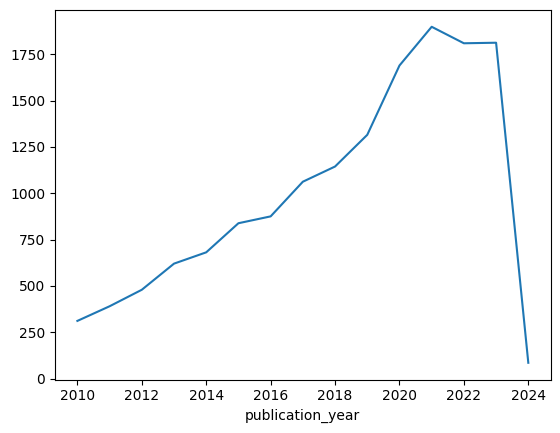

In [9]:
# Overview of publications per year
df.groupby("publication_year").work_id.nunique().plot()

#### 1.c Overview most frequent languages

In [10]:
# overview of languages
languages = df.query("language.notna()")
(pd.DataFrame(languages.groupby("language").
              work_id.nunique()).
              rename(columns={"work_id":"pub_count"}).
              sort_values(by="pub_count", ascending=False).
              head(10))

,pub_count
language,
en,14400
pt,101
fr,86
es,71
de,61
it,55
hr,29
pl,16
id,15


#### 1.d Overview of domains, fields, subfields and topics.

In [11]:
#Overview of Domains
df.groupby("topic_domain").work_id.nunique() # all publications are from the domain Social Sciences because this is a subset from the Social Sciences

topic_domain
Social Sciences    15008
Name: work_id, dtype: int64

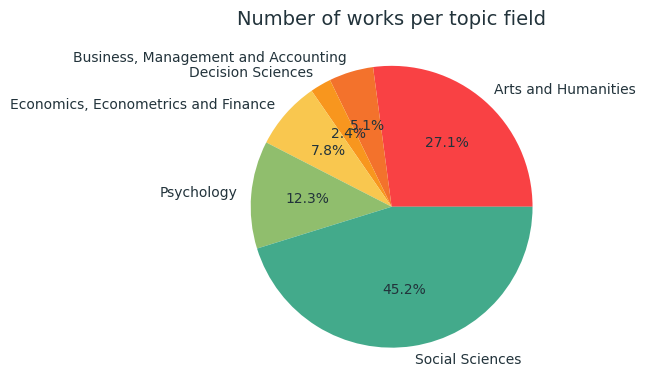

In [12]:
# Overview of topic fields
field_counts = df.groupby("topic_field").work_id.nunique()

colors = ["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.labelcolor': '#22333b',
    'text.color':'#22333b',
    'axes.titlesize': 14,
    'axes.titlepad': 20,
    'legend.fontsize': 10,
    'figure.figsize': (4, 4),
    'lines.linewidth': 2,
    'axes.prop_cycle': plt.cycler(color=colors)  # Set color cycle
})


plt.pie(field_counts, labels=field_counts.index, autopct='%1.1f%%')
plt.title("Number of works per topic field")
plt.axis('equal')
plt.show()


There are 57 subfields present in the data.


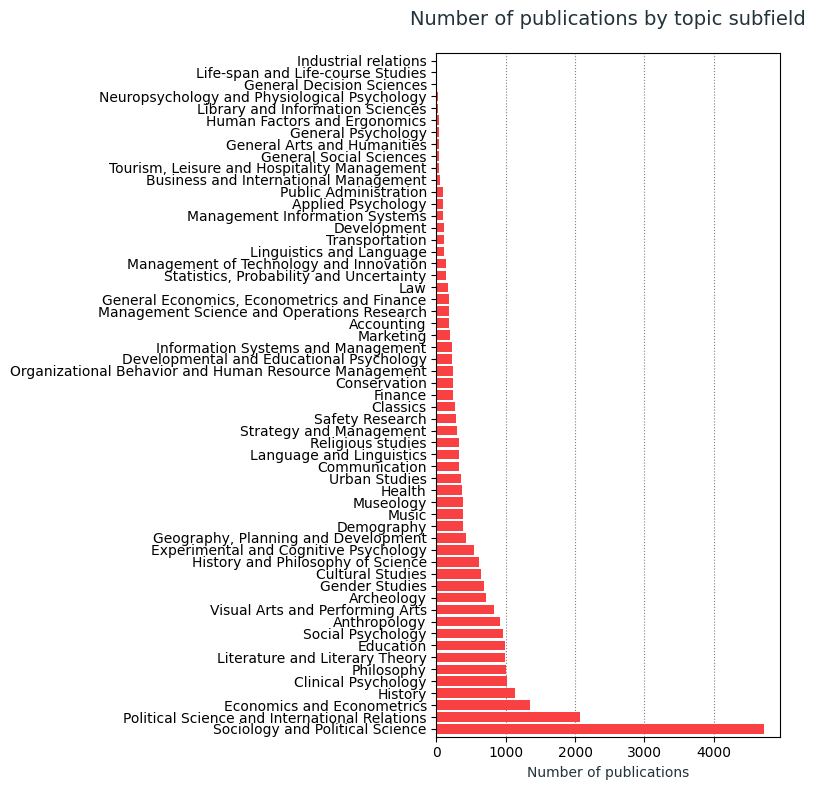

In [13]:
# Overview of the most common topic subfields
print(f"There are {df.topic_subfield.nunique()} subfields present in the data.")

subfield_counts = df.groupby("topic_subfield").work_id.nunique().sort_values(ascending=False)

plt.figure(figsize=(8,8))
subfield_counts.plot(kind='barh', width=0.8, zorder=2)
plt.xlabel('Number of publications')
plt.ylabel(None)
plt.title('Number of publications by topic subfield')
plt.grid(axis='x', color='gray', linestyle=':', zorder=1)
plt.tight_layout()
plt.show()

One step below subfields are the individual topics, of these there are many, so we show them in VosViewer. (add links).

#### 1.e Countries

Number of publications with country code: 12684


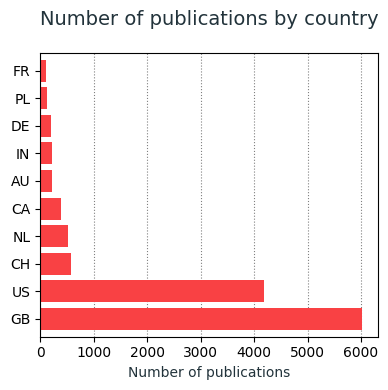

In [14]:
# The country code is often mising, so beware interpreting this!
country_codes = df.query("country_code.notna()")
print(f"Number of publications with country code: {country_codes.work_id.nunique()}")

country_counts = country_codes.groupby("country_code").work_id.nunique().sort_values(ascending=False).head(10) # consider 10 most frequent countries


country_counts.plot(kind='barh', width=0.8, zorder=2)
plt.xlabel('Number of publications')
plt.ylabel(None)
plt.title('Number of publications by country')
plt.grid(axis='x', color='gray', linestyle=':', zorder=1)
plt.tight_layout()
plt.show()


### 2. Single authored publications vs. collaborations

#### 2.a number of single-authored vs. co-authored publications

In [15]:
print(
    f"""
    Of the {works_authors.work_id.nunique()} publications, {works_authors.query("authors_count == 1").work_id.nunique()} were single-authored.
    That is {round((works_authors.query("authors_count == 1").work_id.nunique()/works_authors.work_id.nunique())*100,2)} percent
    """)


    Of the 15008 publications, 9420 were single-authored.
    That is 62.77 percent
    


In [16]:
def create_sizefreq(df):
  sizefreq = pd.DataFrame(df.groupby("authors_count").work_id.nunique()).reset_index()
  bins = [1,2,3,4,5,6,7,8,9,10,11,16,21,26, 31, float('inf')]
  labels = ['1','2','3','4','5','6','7','8','9','10', '11-15','16-20','21-25','26-30', '30+']

  sizefreq['author_bins'] = pd.cut(sizefreq['authors_count'], bins=bins, labels=labels, right=False)


  works_total = sizefreq.work_id.sum()
  sizefreq["percentages"] = (sizefreq.work_id/works_total)*100

  return sizefreq

In [17]:
sizefreq = create_sizefreq(works_authors)

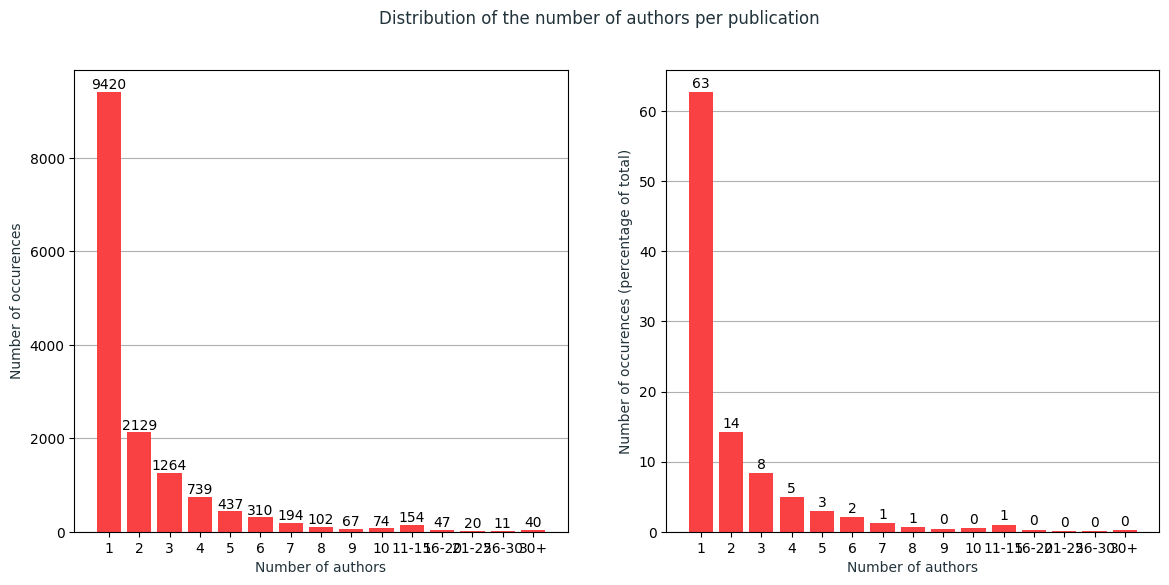

In [18]:
# Number of authors by bin
frequency_df = pd.DataFrame(sizefreq.groupby("author_bins").work_id.sum()).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(frequency_df['author_bins'], frequency_df['work_id'],zorder=2)
ax1.set_xlabel('Number of authors')
ax1.set_ylabel('Number of occurences')

#add the numbers on top of the bar
for bar in bars1:
  yval = bar.get_height()
  ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.0f}', ha='center', va='bottom', color='black', fontsize=10)

ax1.grid(axis='y',zorder=1)


frequency_df_ind = pd.DataFrame(sizefreq.groupby("author_bins").percentages.sum()).reset_index()

bars2 = ax2.bar(frequency_df_ind['author_bins'], frequency_df_ind['percentages'],zorder=2)
ax2.set_xlabel('Number of authors')
ax2.set_ylabel('Number of occurences (percentage of total)')

#add the numbers on top of the bar
for bar in bars2:
  yval = bar.get_height()
  ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.0f}', ha='center', va='bottom', color='black', fontsize=10)

ax2.grid(axis='y',zorder=1)

fig.suptitle('Distribution of the number of authors per publication')

plt.show()

#### 2.b Number of authors per publication compared with OpenAlex

api search "https://api.openalex.org/works?filter=topics.domain.id:1&group_by=authors_count"

In [19]:
def get_response_df(request_string):
  response = requests.get(request_string)
  print(response)
  oa_result = response.json()
  print("total number of articles:", oa_result['meta']['count'])
  groups=oa_result["group_by"]
  df = pd.DataFrame(groups,columns=["key","count"])
  df = df.rename(columns = {"key":"authors_count","count":"work_id"})
  return df

In [20]:
def show_plot_openalex_data(response_df, independent_df=None, percentages=True):
  """Show the plot that compares the independent scholar data with the data gathered from OpenAlex."""
  response_df.authors_count = response_df.authors_count.astype(int)

  #add bins
  bins = [1,2,3,4,5,6,7,8,9,10,11,16,21,26, 31, float('inf')]
  labels = ['1','2','3','4','5','6','7','8','9','10', '11-15','16-20','21-25','26-30', '30+']
  response_df['author_bins'] = pd.cut(response_df['authors_count'], bins=bins, labels=labels, right=False)

  #Calculate the number of works for each number of co-authors.
  response_df = pd.DataFrame(response_df.groupby("author_bins").work_id.sum()).reset_index()
  if percentages==True:
    response_df["counts"] = (response_df.work_id/(response_df.work_id.sum()))*100
  else:
    response_df.rename(columns={"work_id":"counts"})
  if independent_df is not None and not independent_df.empty:
    independent_df = pd.DataFrame(independent_df.groupby("author_bins").work_id.sum()).reset_index()
    if percentages==True:
      independent_df["counts"] = (independent_df.work_id/(independent_df.work_id.sum()))*100
    else:
      independent_df.rename(columns={"work_id":"counts"})

  #plot the figure
  plt.figure(figsize=(10, 6))

  bar_width = 0.35

  # Create the OpenAlex figure
  num_bars1 = len(response_df)
  x_values1 = np.arange(num_bars1)
  bars1 = plt.bar(x_values1, response_df['counts'], color='pink', label='OpenAlex data', zorder=2, width=bar_width)
  for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.0f}', ha='center', va='bottom', color='black', fontsize=10)

  # add independent scholars data
  if independent_df is not None and not independent_df.empty:
    num_bars2 = len(independent_df)
    x_values2 = np.arange(num_bars2) + bar_width
    bars2 = plt.bar(x_values2, independent_df['counts'], color='blue', label='Independent researchers', zorder=2, width=bar_width)

    for bar in bars2:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{yval:.0f}', ha='center', va='bottom', color='black', fontsize=10)

  plt.xlabel('Number of authors')
  plt.ylabel('Number of occurences')
  plt.title('Distribution of the number of authors (SSH)')
  plt.grid(axis='y', color='#D8BFD8',zorder=1)
  plt.legend()
  plt.show()

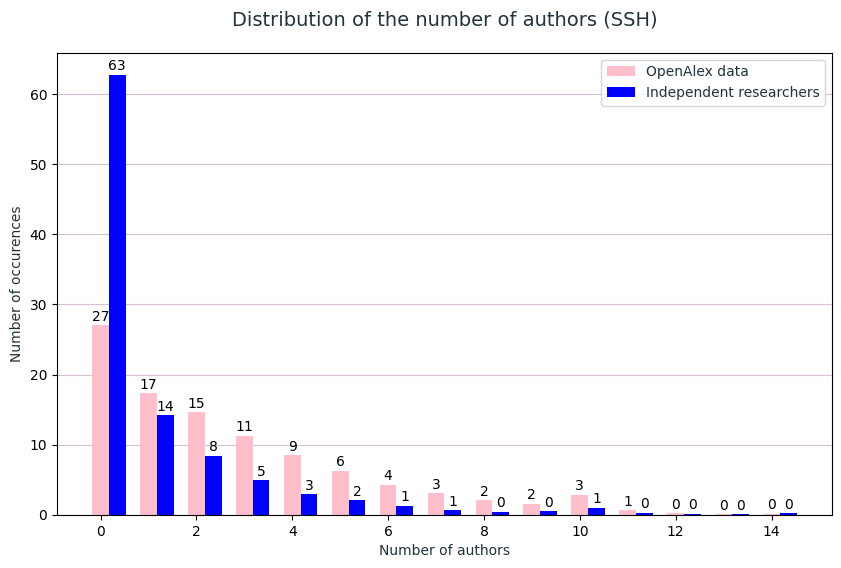

In [21]:
# For the  topic domain 1
#response = get_response_df("https://api.openalex.org/works?filter=topics.domain.id:1&group_by=authors_count")

response = pd.read_csv("author_distribution_domain1.csv")
show_plot_openalex_data(response, sizefreq, percentages=True)

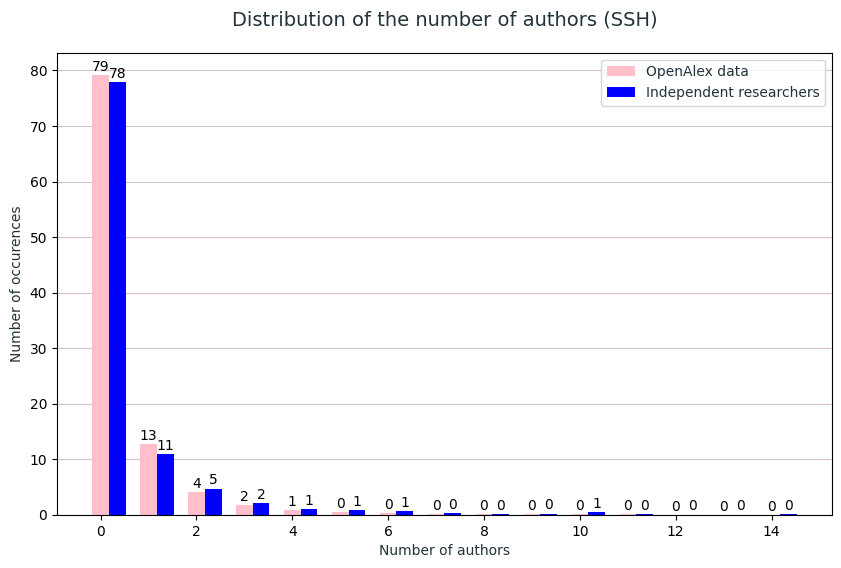

In [22]:
# For field 12 'Arts and Humanities'
field12 = works_authors.query("topic_field == 'Arts and Humanities'")
sizefreq = create_sizefreq(field12)


#response = get_response_df("https://api.openalex.org/works?filter=topics.field.id:12&group_by=authors_count") # get the numbers from the OpenAlex API
response = pd.read_csv("author_distribution_field12.csv")

show_plot_openalex_data(response, sizefreq, percentages=True)


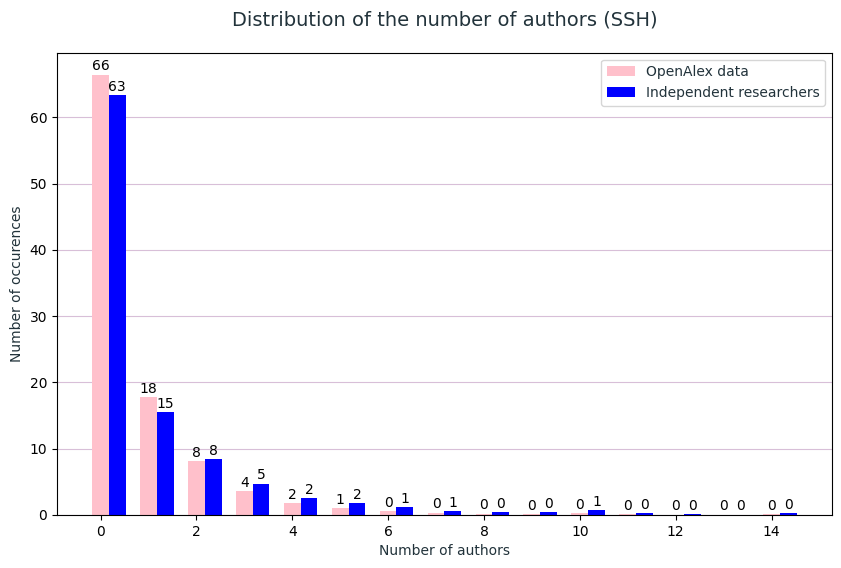

In [23]:
# For field 33 'Social Sciences'

field33 = works_authors.query("topic_field == 'Social Sciences'")
sizefreq = create_sizefreq(field33)

#response = get_response_df("https://api.openalex.org/works?filter=topics.field.id:33&group_by=authors_count")
response = pd.read_csv("author_distribution_field33.csv")

show_plot_openalex_data(response, sizefreq, percentages=True)

### 3. Open Access patterns

In [24]:
# Data gathered from OpenAlex (in separate notebook)
ssh_data = pd.read_csv('all_ssh_oa.csv', index_col = 0)

In [25]:
ssh_data

,oa_status,count,oa_shares,oa_shares_perc_ssh
2,bronze,740669,0.075900,8.0
0,closed,5598802,0.573735,57.0
1,gold,2138079,0.219099,22.0
4,green,628838,0.064440,6.0
3,hybrid,652135,0.066827,7.0


##### Independent scholars SSH

In [26]:
ssh_works_18_22 = df[df['publication_year'].isin(range(2018,2022))]
ssh_works_18_22_filtered = ssh_works_18_22[['work_id', 'oa_status']].drop_duplicates()
ssh_ind_scholars_stats = ssh_works_18_22_filtered.groupby('oa_status').count()
ssh_ind_scholars_stats = ssh_ind_scholars_stats.rename(columns={'work_id': 'count'})
ssh_ind_scholars_stats['oa_shares'] = ssh_ind_scholars_stats['count']/sum(ssh_ind_scholars_stats['count'])
ssh_ind_scholars_stats['oa_shares_perc_ind'] = round(ssh_ind_scholars_stats['oa_shares']*100)
ssh_ind_scholars_stats = ssh_ind_scholars_stats.sort_values(by=['oa_status'])

In [27]:
len(ssh_works_18_22_filtered)

6046

##### Independent scholars SSH first/last author

In [28]:
ssh_authors_1st_last = works_authors[(works_authors['author_position'] == 'first') | (works_authors['author_position'] == 'last')]
ssh_authors_1st_last = ssh_authors_1st_last[['author_id', 'work_id', 'author_position']].drop_duplicates()
ssh_works_authors_1st_last = pd.merge(ssh_works_18_22_filtered, ssh_authors_1st_last, on='work_id')
ssh_ind_scholars_1st_last_stats = ssh_works_authors_1st_last.groupby('oa_status').count()
ssh_ind_scholars_1st_last_stats = ssh_ind_scholars_1st_last_stats[['work_id']]
ssh_ind_scholars_1st_last_stats = ssh_ind_scholars_1st_last_stats.rename(columns={'work_id': 'count'})
ssh_ind_scholars_1st_last_stats['oa_shares'] = ssh_ind_scholars_1st_last_stats['count']/sum(ssh_ind_scholars_1st_last_stats['count'])
ssh_ind_scholars_1st_last_stats['oa_shares_perc_1st'] = round(ssh_ind_scholars_1st_last_stats['oa_shares']*100)
ssh_ind_scholars_1st_last_stats = ssh_ind_scholars_1st_last_stats.sort_values(by=['oa_status'])

In [29]:
len(ssh_works_authors_1st_last)

5441

##### Independent scholars SSH single author

In [30]:
single_author_works = works_authors[(works_authors['authors_count'] == 1)]
single_author_works = single_author_works[single_author_works['publication_year'].isin(range(2018,2022))]
single_author_works = single_author_works[['work_id', 'oa_status']].drop_duplicates()
single_author_stats = single_author_works.groupby('oa_status').count()
single_author_stats = single_author_stats.rename(columns={'work_id': 'count'})
single_author_stats['oa_shares'] = single_author_stats['count']/sum(single_author_stats['count'])
single_author_stats['oa_shares_perc_sole'] = round(single_author_stats['oa_shares']*100)
single_author_stats = single_author_stats.sort_values(by=['oa_status'])

In [31]:
len(single_author_works)

3665

In [32]:
summary_table = ssh_data[['oa_status', 'oa_shares_perc_ssh']]
summary_table.insert(2, 'oa_shares_perc_ind', ssh_ind_scholars_stats['oa_shares_perc_ind'].values)
summary_table.insert(3, 'oa_shares_perc_1st', ssh_ind_scholars_1st_last_stats['oa_shares_perc_1st'].values)
summary_table.insert(4, 'oa_shares_perc_sole', single_author_stats['oa_shares_perc_sole'].values)
summary_table = summary_table.drop(columns=['oa_status'])

In [33]:
summary_table.loc[0:0].values

array([[57., 64., 67., 74.]])

In [34]:
summary_table

,oa_shares_perc_ssh,oa_shares_perc_ind,oa_shares_perc_1st,oa_shares_perc_sole
2,8.0,6.0,6.0,5.0
0,57.0,64.0,67.0,74.0
1,22.0,19.0,17.0,14.0
4,6.0,6.0,6.0,4.0
3,7.0,5.0,4.0,3.0


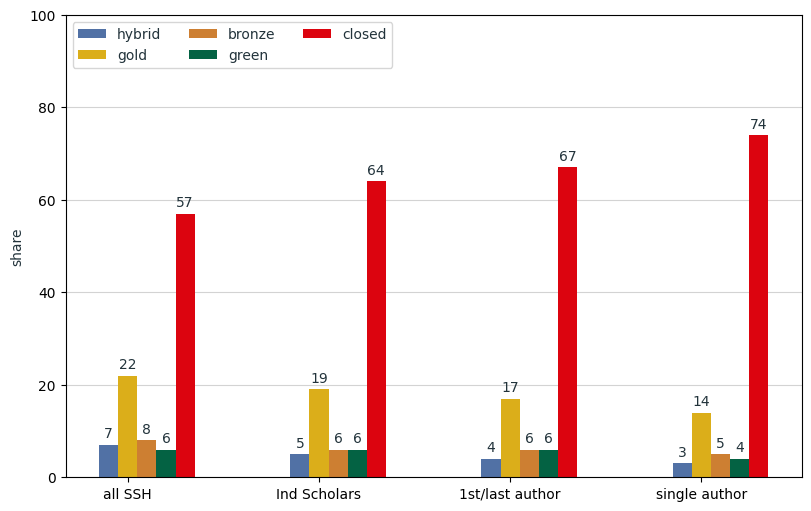

In [35]:
groups = ('all SSH', 'Ind Scholars', '1st/last author', 'single author')
oa_shares = {
    'hybrid': (7,5,4,3),
    'gold': (22,19,17,14),
    'bronze': (8,6,6,5),
    'green': (6,6,6,4),
    'closed': (57,64,67,74)
}

#add the custom colours
colors = {'green': '#046243', 'bronze': '#CD7F32', 'gold': '#DBAE1A', 'closed': '#DC040F', 'hybrid': '#5171A5'}

x = np.arange(len(groups))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,5))

for attribute, measurement in oa_shares.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width,color=colors[attribute], label=attribute, zorder=2)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('share')
#ax.set_title('OA shares for different researcher groups within SSH during 2018-2022')
ax.set_xticks(x + width, groups)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 100)

# Add grid
ax.grid(axis='y', color='lightgrey',zorder=1)

plt.show()